Курсовая работа

06. Классификация: превышает ли значение CC50 медианное значение выборки

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 26.0 MB/s eta 0:00:00


In [4]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import joblib
import optuna
import pickle
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [6]:
# Загрузка  данных
df_standardscaler = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Classic_ML_Vo_PJ/df_standardscaler.csv')

In [7]:
# Выведим размерность датафрейма
df_standardscaler.shape

(969, 188)

In [8]:
# Выведим первые строки датафрейма
df_standardscaler.head()

,IC50,CC50,SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-0.599333,-0.648886,0.023693,-1.766931,-1.766931,1.230105,0.859969,-0.751719,1.076111,0.260487,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
1,-0.623447,-0.917447,-0.258103,-2.112017,-2.112017,2.098636,0.953566,-0.540135,1.257528,0.292155,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
2,0.360199,-0.671529,-0.341875,-2.518530,-2.518530,2.154087,0.959542,-1.485466,1.017293,0.748665,...,6.379466,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
3,-0.619328,-0.755671,0.492044,-1.765937,-1.765937,1.250111,0.862125,-0.937063,0.991464,0.370656,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,3.080565,-0.085302
4,-0.154375,-0.706065,-0.334138,-1.749744,-1.749744,0.538633,0.785453,-0.696952,0.567012,0.905000,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,-0.169372,-0.085302


In [9]:
# Выбираем целевую переменную — это CC50
y = df_standardscaler['CC50']  # Целевая переменная

# Рассчитываем медианное значение CCC50
median_cc50 = y.median()

# Преобразуем задачу регрессии в задачу бинарной классификации:
# - 1: если CC50 > median (высокое значение)
# - 0: если CC50 <= median (низкое значение)
y_binary = (y > median_cc50).astype(int)  # Бинарная целевая переменная


# Формируем матрицу признаков, исключая SI, CC50, IC50
X = df_standardscaler.drop(columns=['SI', 'CC50', 'IC50'])  # Признаки


# Разделяем данные на обучающую и тестовую выборки в соотношении 70:30
# random_state=42 — обеспечивает воспроизводимость результата
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary,
    test_size=0.3,
    random_state=42
)


# Словарь с классами классификаторов, которые будут оптимизироваться
CLASSIFIERS = {
    'XGBClassifier': XGBClassifier,
    'DecisionTreeClassifier': DecisionTreeClassifier,
    'RandomForestClassifier': RandomForestClassifier,
    'CatBoostClassifier': CatBoostClassifier
}


# Функция-объектив для Optuna, которая будет оценивать модель
def objective(trial, classifier_name):
    """ Функция для поиска гиперпараметров модели с помощью Optuna """

    if classifier_name == 'XGBClassifier':
        params = {
            'objective': 'binary:logistic',
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'n_estimators': trial.suggest_int('n_estimators', 50, 550),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        }
        model = XGBClassifier(**params)

    elif classifier_name == 'DecisionTreeClassifier':
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
        model = DecisionTreeClassifier(**params)

    elif classifier_name == 'RandomForestClassifier':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 550),
            'max_depth': trial.suggest_int('max_depth', 1, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
        model = RandomForestClassifier(**params)

    elif classifier_name == 'CatBoostClassifier':
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            'depth': trial.suggest_int('depth', 1, 10),
            'iterations': trial.suggest_int('iterations', 50, 550),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-4, 10, log=True),
            'verbose': 0  # Отключаем выводы обучения
        }
        model = CatBoostClassifier(**params)

    # Обучаем модель
    model.fit(X_train, y_train)

    # Делаем предсказания
    y_pred = model.predict(X_test)

    # Оцениваем качество по метрике accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy  # Возвращаем accuracy как цель оптимизации


# Хранение результатов оптимизации моделей
best_models = {}

# Проходимся по всем классификаторам из словаря CLASSIFIERS
for classifier_name in CLASSIFIERS.keys():
    print(f"Оптимизация гиперпараметров для {classifier_name}...")
    study = optuna.create_study(direction='maximize')  # Создаём исследование Optuna для максимизации accuracy
    study.optimize(lambda trial: objective(trial, classifier_name), n_trials=200)  # Ищем лучшие параметры

    best_params = study.best_params  # Получаем лучшие параметры
    best_model = CLASSIFIERS[classifier_name](**best_params).fit(X_train, y_train)  # Обучаем модель с этими параметрами
    best_models[classifier_name] = {
        'best_params': best_params,   # Лучшие гиперпараметры
        'best_model': best_model      # Лучшая обученная модель
    }

    print(f"Лучшие гиперпараметры для {classifier_name}:")
    print(best_params)


# Оценка качества моделей на тестовых данных
print("\n=== Результаты на тестовых данных ===\n")
for classifier_name, model_data in best_models.items():
    best_model = model_data['best_model']
    y_test_pred = best_model.predict(X_test)

    # Подсчёт метрик
    accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    # Вывод результатов
    print(f"{classifier_name}")
    print(f"  Тестовая точность: {accuracy:.4f}")
    print(f"  Тестовый F1-score: {f1:.4f}\n")

[I 2025-06-12 13:11:44,396] A new study created in memory with name: no-name-8a163504-dbfa-4874-b3d2-ca2086725b72


Оптимизация гиперпараметров для XGBClassifier...


[I 2025-06-12 13:11:55,827] Trial 0 finished with value: 0.7766323024054983 and parameters: {'learning_rate': 0.0014520863958916044, 'max_depth': 10, 'n_estimators': 356, 'subsample': 0.7293993562994456, 'colsample_bytree': 0.5212148659831195}. Best is trial 0 with value: 0.7766323024054983.
[I 2025-06-12 13:11:56,914] Trial 1 finished with value: 0.7525773195876289 and parameters: {'learning_rate': 0.0008403019856717246, 'max_depth': 9, 'n_estimators': 89, 'subsample': 0.5140298499546931, 'colsample_bytree': 0.9706505800915296}. Best is trial 0 with value: 0.7766323024054983.
[I 2025-06-12 13:12:02,452] Trial 2 finished with value: 0.7594501718213058 and parameters: {'learning_rate': 0.00019769850972555707, 'max_depth': 9, 'n_estimators': 504, 'subsample': 0.6078425266916413, 'colsample_bytree': 0.7901379695285957}. Best is trial 0 with value: 0.7766323024054983.
[I 2025-06-12 13:12:10,211] Trial 3 finished with value: 0.7697594501718213 and parameters: {'learning_rate': 0.01991982096

Лучшие гиперпараметры для XGBClassifier:
{'learning_rate': 0.14286127959526837, 'max_depth': 11, 'n_estimators': 243, 'subsample': 0.7406821918066807, 'colsample_bytree': 0.5375759833686096}
Оптимизация гиперпараметров для DecisionTreeClassifier...


[I 2025-06-12 13:18:18,557] Trial 5 finished with value: 0.7285223367697594 and parameters: {'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.7525773195876289.
[I 2025-06-12 13:18:18,575] Trial 6 finished with value: 0.6907216494845361 and parameters: {'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 3 with value: 0.7525773195876289.
[I 2025-06-12 13:18:18,593] Trial 7 finished with value: 0.6907216494845361 and parameters: {'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.7525773195876289.
[I 2025-06-12 13:18:18,637] Trial 8 finished with value: 0.7250859106529209 and parameters: {'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.7525773195876289.
[I 2025-06-12 13:18:18,685] Trial 9 finished with value: 0.7216494845360825 and parameters: {'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 3 with 

Лучшие гиперпараметры для DecisionTreeClassifier:
{'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 5}
Оптимизация гиперпараметров для RandomForestClassifier...


[I 2025-06-12 13:18:31,822] Trial 0 finished with value: 0.7560137457044673 and parameters: {'n_estimators': 517, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7560137457044673.
[I 2025-06-12 13:18:32,137] Trial 1 finished with value: 0.7835051546391752 and parameters: {'n_estimators': 82, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.7835051546391752.
[I 2025-06-12 13:18:33,763] Trial 2 finished with value: 0.7869415807560137 and parameters: {'n_estimators': 536, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.7869415807560137.
[I 2025-06-12 13:18:34,326] Trial 3 finished with value: 0.7731958762886598 and parameters: {'n_estimators': 172, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.7869415807560137.
[I 2025-06-12 13:18:34,635] Trial 4 finished with value: 0.7457044673539519 and parameters: {'n_

Лучшие гиперпараметры для RandomForestClassifier:
{'n_estimators': 533, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 1}
Оптимизация гиперпараметров для CatBoostClassifier...


[I 2025-06-12 13:24:11,284] Trial 0 finished with value: 0.7835051546391752 and parameters: {'learning_rate': 0.8934445541823525, 'depth': 6, 'iterations': 374, 'l2_leaf_reg': 3.691081253965023}. Best is trial 0 with value: 0.7835051546391752.
[I 2025-06-12 13:24:12,110] Trial 1 finished with value: 0.7422680412371134 and parameters: {'learning_rate': 0.010737473615426226, 'depth': 2, 'iterations': 302, 'l2_leaf_reg': 2.20195249030571}. Best is trial 0 with value: 0.7835051546391752.
[I 2025-06-12 13:24:15,838] Trial 2 finished with value: 0.7938144329896907 and parameters: {'learning_rate': 0.9770415262774061, 'depth': 6, 'iterations': 240, 'l2_leaf_reg': 1.1999682168532935}. Best is trial 2 with value: 0.7938144329896907.
[I 2025-06-12 13:25:08,914] Trial 3 finished with value: 0.7457044673539519 and parameters: {'learning_rate': 0.2851068596859821, 'depth': 9, 'iterations': 472, 'l2_leaf_reg': 0.010990804687399481}. Best is trial 2 with value: 0.7938144329896907.
[I 2025-06-12 13:25

0:	learn: 0.6788984	total: 257ms	remaining: 55.4s
1:	learn: 0.6639900	total: 530ms	remaining: 56.7s
2:	learn: 0.6564178	total: 843ms	remaining: 59.9s
3:	learn: 0.6408305	total: 1.09s	remaining: 57.9s
4:	learn: 0.6271698	total: 1.4s	remaining: 59.1s
5:	learn: 0.6151858	total: 1.67s	remaining: 58.4s
6:	learn: 0.6038509	total: 1.95s	remaining: 58.2s
7:	learn: 0.5926700	total: 2.23s	remaining: 57.9s
8:	learn: 0.5854444	total: 2.46s	remaining: 56.6s
9:	learn: 0.5747959	total: 2.62s	remaining: 53.9s
10:	learn: 0.5592278	total: 2.77s	remaining: 51.7s
11:	learn: 0.5482200	total: 2.93s	remaining: 49.8s
12:	learn: 0.5360532	total: 3.1s	remaining: 48.5s
13:	learn: 0.5265303	total: 3.26s	remaining: 47.1s
14:	learn: 0.5146298	total: 3.42s	remaining: 45.9s
15:	learn: 0.5072204	total: 3.58s	remaining: 44.7s
16:	learn: 0.4987030	total: 3.74s	remaining: 43.8s
17:	learn: 0.4913726	total: 3.9s	remaining: 42.9s
18:	learn: 0.4821314	total: 4.07s	remaining: 42.2s
19:	learn: 0.4710457	total: 4.23s	remaining:

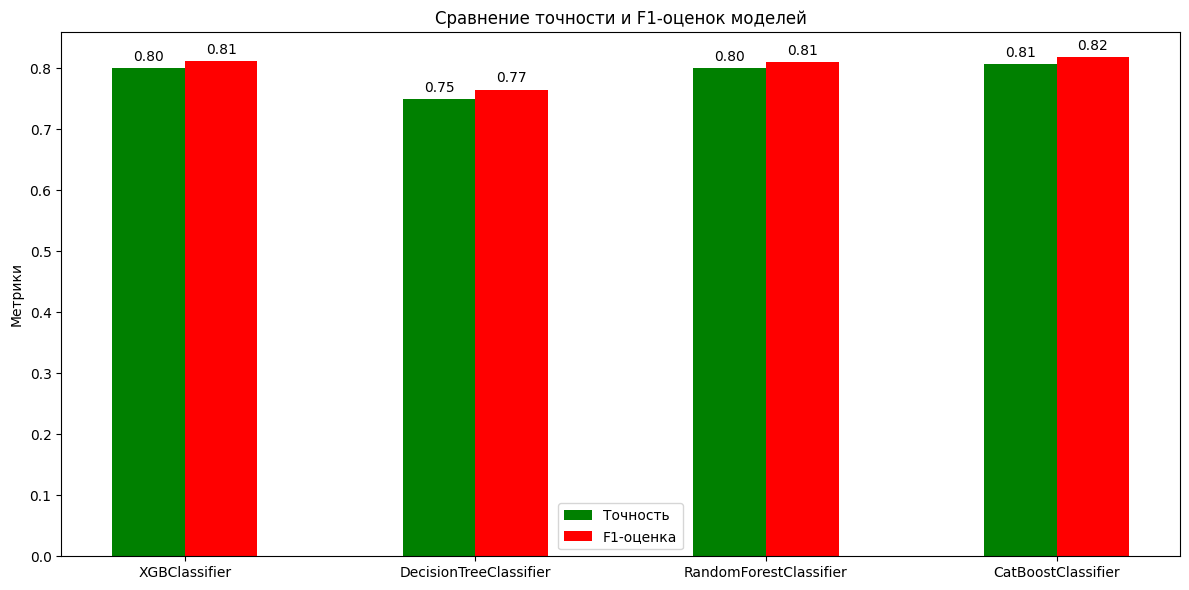

In [10]:
# Списки для хранения метрик моделей: точности (accuracy) и F1-оценки
models_names = list(best_models.keys())  # Получаем названия всех моделей из best_models
accuracies = []  # Список для сохранения значений accuracy
f1_scores = []   # Список для сохранения значений F1-score

# Цикл для вычисления метрик для каждой модели
for classifier_name, model_data in best_models.items():
    best_model = model_data['best_model']
    y_test_pred = best_model.predict(X_test)

    # Вычисляем метрики
    accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    # Добавляем результаты в списки
    accuracies.append(accuracy)
    f1_scores.append(f1)


x = np.arange(len(models_names))  # Массив индексов для размещения столбцов
width = 0.25
# Создаём график размером 12x6
fig, ax = plt.subplots(figsize=(12, 6))

# Строим два набора столбцов:
bars1 = ax.bar(x - width/2, accuracies, width, label='Точность', color='green')
bars2 = ax.bar(x + width/2, f1_scores, width, label='F1-оценка', color='red')

# Настраиваем ось Y и заголовок графика
ax.set_ylabel('Метрики')
ax.set_title('Сравнение точности и F1-оценок моделей')
ax.set_xticks(x)
ax.set_xticklabels(models_names)
ax.legend()


# Функция для добавления численных значений на верхушку каждого столбца
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Добавляем значения на обе группы столбцов
add_labels(bars1)
add_labels(bars2)

plt.tight_layout()

# Отображаем график
plt.show()


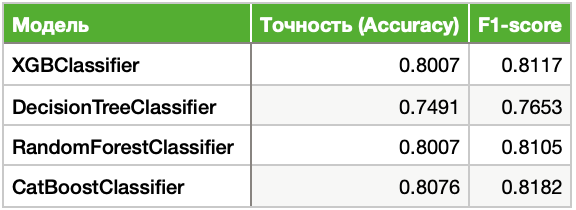


1. CatBoostClassifier показывает наилучшие результаты, меет наивысшую точность (Accuracy) и F1-score, что говорит о его лучшей способности корректно классифицировать объекты.


2. XGBoost и RandomForest имеют сопоставимые результаты, обе модели демонстрируют очень близкие значения метрик:
Accuracy: 0.8007
F1-score: ~0.811



3. DecisionTreeClassifier уступает остальным моделям, имеет значительно худшую точность и F1-score, чем остальные модели, не смогло полностью выявить сложные закономерности в данных.



4. Высокие значения метрик указывают на хорошее качество моделирования
Все модели показали выше среднего Accuracy и F1-score, что говорит о хорошем соответствии модели реальным данным.
Особенно высокий F1-score у CatBoost (~0.818), что подтверждает баланс между precision и recall.

 Вывод:

- CatBoostClassifier — самая эффективная модель для данной задачи, является лидером по всем ключевым метрикам.

- XGBoost и RandomForestClassifier являются альтернативами, которые могут использоваться в зависимости от требований к интерпретируемости и производительности.

- DecisionTreeClassifier не рекомендуется использовать как основную модель в этой задаче.

In [11]:
def save_model(model, model_name):
    """ Сохраняет модель в файл с расширением .pkl """
    filename = f"{model_name}_CC50.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
        print(f"Модель '{filename}' сохранена.")


def load_model(model_name):
    """ Загружает ранее сохранённую модель из файла """
    filename = f"{model_name}_CC50.pkl"
    try:
        with open(filename, 'rb') as file:
            model = pickle.load(file)
        print(f"Модель '{filename}' загружена.")
        return model
    except FileNotFoundError:
        print(f"Ошибка: файл '{filename}' не найден.")  # Сообщаем об ошибке, если файл отсутствует
        return None  # Возвращаем None при ошибке


# Сохраняем каждую из оптимальных моделей в отдельный файл
for classifier_name, model_data in best_models.items():
    save_model(model_data['best_model'], classifier_name)


# Загружаем все модели обратно из файлов
loaded_models = {
    'XGBClassifier': load_model('XGBClassifier'),
    'DecisionTreeClassifier': load_model('DecisionTreeClassifier'),
    'RandomForestClassifier': load_model('RandomForestClassifier'),
    'CatBoostClassifier': load_model('CatBoostClassifier')
}

Модель 'XGBClassifier_CC50.pkl' сохранена.
Модель 'DecisionTreeClassifier_CC50.pkl' сохранена.
Модель 'RandomForestClassifier_CC50.pkl' сохранена.
Модель 'CatBoostClassifier_CC50.pkl' сохранена.
Модель 'XGBClassifier_CC50.pkl' загружена.
Модель 'DecisionTreeClassifier_CC50.pkl' загружена.
Модель 'RandomForestClassifier_CC50.pkl' загружена.
Модель 'CatBoostClassifier_CC50.pkl' загружена.


In [12]:
# Проверка загруженной модели
for name, model in loaded_models.items():
    if model is not None:
        y_test_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred)
        print(f"{name} - Тестовые метрики после загрузки:")
        print(f"  Accuracy: {acc:.4f}")
        print(f"  F1-score: {f1:.4f}\n")
    else:
        print(f"Модель '{name}_CC50.pkl' НЕ загружена — файл не найден.\n")

XGBClassifier - Тестовые метрики после загрузки:
  Accuracy: 0.8007
  F1-score: 0.8117

DecisionTreeClassifier - Тестовые метрики после загрузки:
  Accuracy: 0.7491
  F1-score: 0.7653

RandomForestClassifier - Тестовые метрики после загрузки:
  Accuracy: 0.8007
  F1-score: 0.8105

CatBoostClassifier - Тестовые метрики после загрузки:
  Accuracy: 0.8076
  F1-score: 0.8182



In [13]:
import os
# Проверяем все файлы в текущей директории
os.listdir()

['.config',
 'DecisionTreeClassifier_CC50.pkl',
 'CatBoostClassifier_CC50.pkl',
 'drive',
 'RandomForestClassifier_CC50.pkl',
 'catboost_info',
 'XGBClassifier_CC50.pkl',
 'sample_data']